# Time Series Forecasting COVID-19 Cases

A time series is a set of observations recorded over time. Used typically in forecasting, the set of observations are recorded with a regular frequency, like daily or monthly.

For our case, we shall study the data pertaining to the COVID-19 active cases worldwide, from Jan 2020 to Jul 2020.

Data is obtained from: https://www.kaggle.com/datasets/imdevskp/corona-virus-report

In [306]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [307]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Data

Extracts data from the dataset and extract lag features. To make a lag feature we shift the observations of the target series from a previous timestamp so that they appear to have occured at a later timestamp. (Lag features are taken from 2, 4, 6, 8 and 10 days prior data mapped to `Lag_1, Lag_2, Lag_3, Lag_4, Lag_5` respectively)

We then visualize for any relationships between the lag features and current active cases using linear regresssion, and map out the trend using moving average data.

In [308]:
df = pd.read_csv('./drive/MyDrive/day_wise.csv', index_col='Date', parse_dates=['Date'])

# lag feature to shift observations from the previous days to current day
df['Lag_1'] = df['Active'].shift(2)
df['Lag_2'] = df['Active'].shift(4)
df['Lag_3'] = df['Active'].shift(6)
df['Lag_4'] = df['Active'].shift(8)
df['Lag_5'] = df['Active'].shift(10)

df = df.loc[:, ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5', 'Active']].dropna()
df.head(5)

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Active
Date,,,,,,
2020-02-01,7922.0,5340.0,2010.0,879.0,510.0,11498
2020-02-02,9495.0,5908.0,2784.0,1353.0,606.0,15966
2020-02-03,11498.0,7922.0,5340.0,2010.0,879.0,18857
2020-02-04,15966.0,9495.0,5908.0,2784.0,1353.0,22585
2020-02-05,18857.0,11498.0,7922.0,5340.0,2010.0,26008


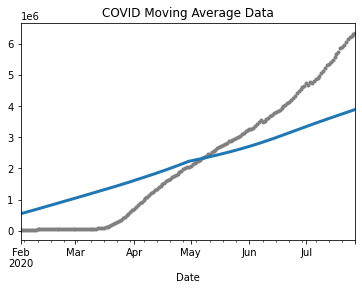

In [309]:
# Visualise an general increasing trend from the moving average
active_df = df['Active']
moving_average = active_df.rolling(window=178, center=True, min_periods=89).mean()             
ax = active_df.plot(style=".", color='gray')
moving_average.plot(ax=ax, linewidth=3, title="COVID Moving Average Data", legend=False)

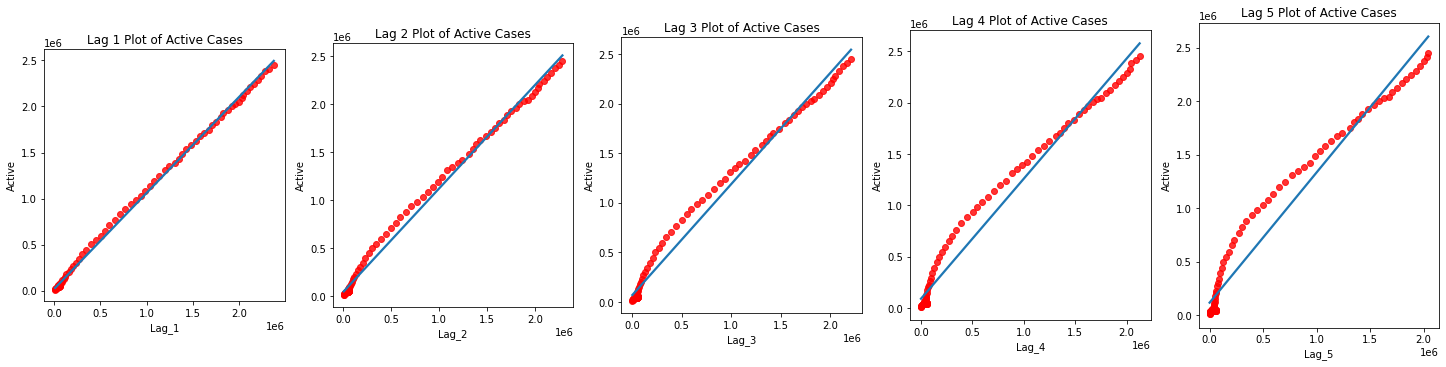

In [310]:
# linear regression plot of lag against active cases for the first 100 sample points

fig, ax = plt.subplots(2, 2, figsize=(25, 25))

for i in range(1, 5+1):
  plt.subplot(1, 5, i)
  ax = sns.regplot(x=f'Lag_{i}', y='Active', data=df.head(100), ci=None, scatter_kws=dict(color='red'))
  ax.set_aspect('equal')
  ax.set_title(f'Lag {i} Plot of Active Cases');

Using `sklearn.linear_model.LinearRegression`, we train a simple Linear Regression Model.

In [311]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# convert DataFrame to numpy array
data = df.to_numpy()
X = data[:, :-1]
y = data[:, -1].reshape(-1, 1)
print(X.shape, y.shape)

# split data into train and val (first 125 for train, next 53 for val)
X_train, X_val, y_train, y_val = X[:126, :], X[126: , :], y[:126, :], y[126:, :]
ss_x = StandardScaler()
ss_y = StandardScaler()

X_train = ss_x.fit_transform(X_train) 
y_train = ss_y.fit_transform(y_train)

X_val = ss_x.transform(X_val)
y_val = ss_y.transform(y_val)




(178, 5) (178, 1)


Text(0.5, 1.0, 'Time series of COVID Active Cases')

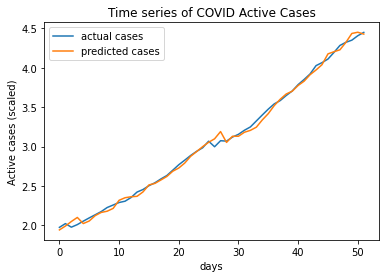

In [312]:
from sklearn.linear_model import LinearRegression

model_linreg = LinearRegression()
model_linreg.fit(X_train, y_train)
y_pred = model_linreg.predict(X_val)

# Plot Linear Regression Model for Time Series of Active COVID Cases
plt.plot(y_val, label='actual cases')
plt.plot(y_pred, label='predicted cases')
plt.xlabel('days')
plt.ylabel('Active cases (scaled)')
plt.legend()
plt.title('Time series of COVID Active Cases')

In [313]:
# Predicted vs Actual Active COVID Cases World Wide Over Time
y_lin_pred = ss_y.inverse_transform(y_pred).reshape(1, -1)
y_lin_actual = ss_y.inverse_transform(y_val).reshape(1, -1)
df = pd.DataFrame({'Predicted': y_lin_pred[0], 'Actual': y_lin_actual[0]})
df.head(10)

,Predicted,Actual
0,3.445790e+06,3483577.0
1,3.502425e+06,3538590.0
2,3.569952e+06,3486196.0
3,3.629756e+06,3524135.0
4,3.539714e+06,3574922.0
5,3.577542e+06,3623295.0
6,3.656981e+06,3669280.0
7,3.703543e+06,3715937.0
8,3.721593e+06,3776026.0
9,3.762995e+06,3812839.0


## Model Definition

We now proceed to set up another model to predict COVID active cases. (LSTM model) 

Then we will set up the training loop and run it for 100 epochs.

In [314]:
def create_sequences(input_X, input_y):
    # window = 5 (Lag 1 to Lag 5)
    X_train_seq = torch.split(input_X, 1)
    y_train_seq = torch.split(input_y, 1)
    X_train_seq = [x.reshape(5,) for x in X_train_seq]
    y_train_seq = [y.reshape(1,) for y in y_train_seq]
    return X_train_seq, y_train_seq

# convert to tensors and feed train data into the create sequences function
X_train = torch.from_numpy(X_train).type(torch.float32)
y_train = torch.from_numpy(y_train).type(torch.float32)

X_val = torch.from_numpy(X_val).type(torch.float32)
y_val = torch.from_numpy(y_val).type(torch.float32)

X_train_tensor, y_train_tensor = create_sequences(X_train, y_train)
X_train_tensor[0], y_train_tensor[0]

(tensor([-0.9891, -0.9669, -0.9463, -0.9242, -0.9016]), tensor([-1.0107]))

In [315]:
from torch import nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers):
        super().__init__()
        self.num_classes = num_classes  # number of output classes/output size (=1, since predict for current)
        self.num_layers = num_layers    # number of recurrent layers
        self.input_size = input_size    # input size (=1, since only one predictor, but a seqeunce of prev val)
        self.hidden_size = hidden_size  # hidden state and cell state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers)
        self.linear_layer = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        
    def forward(self, x: torch.Tensor):
        h0 = torch.rand(self.num_layers, 1, self.hidden_size)
        c0 = torch.rand(self.num_layers, 1, self.hidden_size)

        lstm_output, (hn, cn) = self.lstm(x.view(len(x), 1, -1), (h0, c0))
        out = self.linear_layer(lstm_output.view(len(x), -1))
        return out[-1]

In [316]:
# defining the model
model_LSTM = LSTMModel(input_size=1, hidden_size=50, num_classes=1, num_layers=2)

# hyperparameters in our model
loss_func = torch.nn.MSELoss()  
opt_func = torch.optim.Adam
lr = 0.001
optimizer = opt_func(params=model_LSTM.parameters(), lr=lr)

## Training Our Model

In [317]:
# training loop

EPOCHS = 100

torch.manual_seed(42)
for epoch in range(EPOCHS):

  for i in range(len(X_train_tensor)):
    X_seq = X_train_tensor[i]
    y_label = y_train_tensor[i]

    model_LSTM.train()
    out = model_LSTM(X_seq)

    # obtain the loss function
    loss = loss_func(out, y_label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if epoch % 10 == 0:
    print(f"Epoch [{epoch}], train loss: {loss.item():.7f}") 

print(f"Epoch [{epoch}], train loss: {loss.item():.7f}") 

Epoch [0], train loss: 0.0079990
Epoch [10], train loss: 0.0001494
Epoch [20], train loss: 0.0020716
Epoch [30], train loss: 0.0069796
Epoch [40], train loss: 0.0000584
Epoch [50], train loss: 0.0014405
Epoch [60], train loss: 0.0002243
Epoch [70], train loss: 0.0000477
Epoch [80], train loss: 0.0008135
Epoch [90], train loss: 0.0000161
Epoch [99], train loss: 0.0000000


In [318]:
model_LSTM.eval()
with torch.inference_mode():
  y_val_pred = []
  X_val_tensor, y_val_tensor = create_sequences(X_val, y_val)
  for i in range(len(X_val_tensor)):
    X_val_seq = X_val_tensor[i]
    y_val_pred.append(model_LSTM(X_val_seq).item())

# convert predictions and actual validation data back to numpy array 
y_val_pred = np.array(y_val_pred).reshape(-1, 1)
y_val_actual = y_val.reshape(52,).numpy().reshape(-1, 1)

# perform inverse scaling on scaled numpy array
y_val_pred = ss_y.inverse_transform(y_val_pred)
y_val_actual = ss_y.inverse_transform(y_val_actual)

## Analysis of Results

The predictions made by our LSTM are donoted by the orange line. The inefficency of the algorithm after 100 epochs may stem from factors like:
- unpredictablity of COVID spread during the early days of the virus
- inaccuracy of data collection worldwide

For future consideration:
- Tuning hyperparameters to our LSTM model (layers, hidden states, etc)
- Increasing window size, which is the length of the sequence time in the analysis
- Collecting more data (over longer period of time and using more features, such as number of COVID deaths, recovered cases, etc)


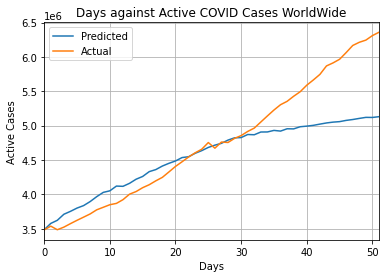

In [320]:
plt.title('Days against Active COVID Cases WorldWide')
plt.ylabel('Active Cases')
plt.xlabel('Days')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(y_val_pred, label='Predicted')
plt.plot(y_val_actual, label='Actual')
plt.legend()
plt.show()

## References

- https://cnvrg.io/pytorch-lstm/
- https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series
- https://levelup.gitconnected.com/forecasting-walmart-quarterly-revenue-pytorch-lstm-example-b4e4b20862a7
- https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/